## Customer Lifetime Value
#### The purporse of the customer lifetime value metric is to asses the financial value of each customer and predict repeat purchases from a customer. We asume that when a customer is Alive, is actively purchasing and wen Dies, became disinterested with your product)


In [1]:
import pandas as pd
import lifetimes
import numpy as np
import datetime as dt
import matplotlib
%matplotlib inline

We will convert the string columns to datetime objects to perform the different calculations and present the necessary variables for the prediction

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

In [3]:
#we parse the columns with the function to convert them to a datetime object
data_raw = pd.read_csv("clientes_unicos.csv", sep=",", parse_dates= ['date_of_birth', 'departure_date_leg'],date_parser= dateparse)


In [4]:
data_raw.tail(10)

,Unnamed: 0,rloc,full_name,gender,age,date_of_birth,document_type,document_number,document_country,nationality,...,distance_seg,route,network,airline_code_seg,flight_number_seg,flight_type,revenue_amount_seg,emd_count,emd_amount,fuel_surcharge_amount_seg
523531,523531,RLKKS2,QZ/QXWQVAZMEE,F,52,1964-05-07,P,WK950O8VS,QGP,QGP,...,1125.102847,BRU-RGS,Europe,XX,5163,I,37.72,NaN,NaN,25.56
523532,523532,I7Y7LT,QFDM OXMUDQTQDNQDFL/B,F,49,1967-03-11,P,X5TX9O8VT,NaN,QGP,...,7402.762966,BRU-RLK,World,XX,19,I,0.00,NaN,NaN,355.06
523533,523533,6V88Q9,IUXTQXY BMGXNXAU/TQDNQDF,M,77,1939-10-01,P,XR3YJOOV6,QGP,QGP,...,1318.093095,BRU-SCQ,Europe,XX,591,I,19.35,NaN,NaN,22.43
523534,523534,6V88Q9,IUXTQXY BMGXNXAU/TQDNQDF,M,77,1939-10-01,P,XR3YJOOV6,QGP,QGP,...,1318.093095,BRU-SCQ,Europe,XX,501,I,19.35,NaN,NaN,22.43
523535,523535,6V88Q9,IUXTQXY BMGXNXAU/TQDNQDF,M,77,1939-10-01,P,XR3YJOOV6,QGP,QGP,...,6610.159533,BRU-DAY,World,XX,0,I,98.31,NaN,NaN,113.97
523536,523536,6V88Q9,IUXTQXY BMGXNXAU/TQDNQDF,M,77,1939-10-01,P,XR3YJOOV6,QGP,QGP,...,6610.159533,BRU-DAY,World,XX,9,I,98.31,NaN,NaN,113.97
523537,523537,D2870B,QZ/PMZMBQFQDE,F,36,1980-04-27,P,ZWLH8OR34,QGP,QGP,...,1571.058104,ALG-BRU,World,XX,4762,I,13.84,NaN,NaN,23.81
523538,523538,D2870B,QZ/PMZMBQFQDE,F,36,1980-04-27,P,ZWLH8OR34,QGP,QGP,...,7894.805996,BRU-TYR,World,XX,43,I,68.66,NaN,NaN,118.19
523539,523539,D2870B,QZ/PMZMBQFQDE,F,36,1980-04-27,P,ZWLH8OR34,QGP,QGP,...,1571.058104,ALG-BRU,World,XX,422,I,13.84,NaN,NaN,23.81
523540,523540,D2870B,QZ/PMZMBQFQDE,F,36,1980-04-27,P,ZWLH8OR34,QGP,QGP,...,7894.805996,BRU-TYR,World,XX,32,I,68.66,NaN,NaN,118.19


## Residual Lifetime Value¶
We will use the beta-geometric/NBD model, an alternative to the Pareto/NBD model developed to describe repeat-buying behaviors in a setting where customers buy at a steady rate (or in a stochastic manner) for a period of time, and then become inactive (die). 
More specifically, the churn rate is modelled using the Pareto (exponential-gamma mixture) timing model but while the customer is still active, his repeat-buying behavior is modelled using the negative binomial (Poisson-gamma) counting mode. Thus, this model yields the expressions required for making individual-level statements about future buying behavior.

In [5]:
#we select the different columns we'll use for the calculations
data = data_raw[['document_number', 'age', 'date_of_birth', 'departure_date_leg', 'route', 'revenue_amount_seg']]

We create the input variables of the model taking into account the dates of the flight purchase. For estimating the probability of a new purchase, the BG/NBD model needs three variables: recency, number of repeat purchases (frequency) and the duration between a customer's first purchase and the end of the period under study (or time being customer in the selected period).

We'll firstly set the "Now" variable like the most recent date of the database. Recency is the duration between a customer's first purchase and their latest purchase. First is the difference between date of birth of the customer and his/her first purchase

In [6]:
#our period of study ends 2014-01-01
data['NOW'] = dt.datetime(2014,1,1)

In [7]:
data['Recency'] = data['departure_date_leg']
data['First'] = data['departure_date_leg'] - data['date_of_birth']
data['age'] = data['NOW'] - data['departure_date_leg']
#the output will be timedelta64

In [8]:
#we transform timedelta64 into an integer in days
fun = lambda x : x.days

data['First'] = data['First'].apply(fun)
data['age'] = data['age'].apply(fun)

In [11]:
data['First'].head(2)

0    21315
1    21316
Name: First, dtype: int64

In [12]:
rfmTable = data.groupby(['document_number']).agg({'Recency': lambda x: (x.max() - x.min()), 
                                                   'route': lambda x: len(x),  
                                                    'age': lambda x:  x.max(),
                                                  'revenue_amount_seg': lambda x: x.sum()
                                                                                               })

In [13]:
#change the names of the columns to adapt them to the lifetimes model
rfmTable.rename(columns={'Recency': 'R',
                         'route': 'F', 
                         'age': 'T', 
                         'revenue_amount_seg': 'M'}, inplace=True)

In [14]:
rfmTable.head(10)

,F,R,T,M
document_number,,,,
000005678,4,8 days,92,2900.00
00000S942,4,60 days,181,212.96
00002BO36,19,313 days,348,7090.58
00003BJ30,1,0 days,11,210.64
00003BO60,2,3 days,211,55.00
00004BQ89,2,2 days,266,0.00
00005BH10,12,89 days,352,2363.00
00005Y755,4,15 days,188,1076.40
00007BP32,3,12 days,83,624.35


R stands for recency.

F is the number of repeat purchases on an specific route that the customer has made (commonly called frequency). 

T is the duration between a customer's first purchase and the end of the period under study.

M is the economic value of each transaction that will be used in a second model for estimating the customer's lifetime value.

In [17]:
rfmTable.head(10)

,F,R,T,M
document_number,,,,
000005678,4,8,92,2900.00
00000S942,4,60,181,212.96
00002BO36,19,313,348,7090.58
00003BJ30,1,0,11,210.64
00003BO60,2,3,211,55.00
00004BQ89,2,2,266,0.00
00005BH10,12,89,352,2363.00
00005Y755,4,15,188,1076.40
00007BP32,3,12,83,624.35


We introduce the variables into the BetaGeoFitter model to predict the next purchase

In [18]:
from lifetimes import BetaGeoFitter 
bgf = BetaGeoFitter()
bgf.fit(rfmTable['F'], rfmTable['R'], rfmTable['T'])
print bgf

<lifetimes.BetaGeoFitter: fitted with 175333 subjects, a: 1.61, alpha: 0.00, b: 3.97, r: 0.08>


//anaconda/lib/python2.7/site-packages/lifetimes/estimation.py:685: RuntimeWarning: overflow encountered in double_scalars
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


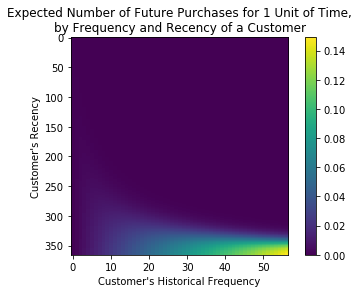

In [15]:
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)

We can see above the Frecuency-Recency Matrix. 
The results show that that if an airline customer has bought flights more than 50 times from you, and his latest purchase was when he was 355 days old, then he is your best customer (bottom-right, yellow area): they are about to make a purchase. 
Our coldest airline customers are those that are in the top-right corner, because they bought a lot quickly but they haven't bought again in the period (if they have made only 1 purchase, the value for recency is 0)

This matrix shows the probability of still being alive:

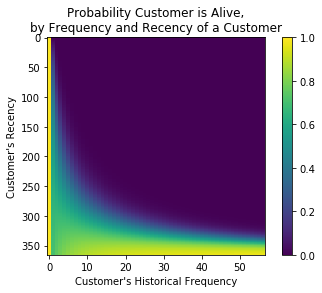

In [20]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

The next table shows a rank from the highest expected purchases in the next period to the lowest. Models expose a method that will predict a customer's expected purchases in the next period using their history.



In [21]:
t = 1
rfmTable['predicted_purchases'] = rfmTable.apply(lambda r: bgf.conditional_expected_number_of_purchases_up_to_time(t, r['F'], r['R'], r['T']), axis=1)
rfmTable.sort('predicted_purchases').tail(5)

//anaconda/lib/python2.7/site-packages/lifetimes/estimation.py:685: RuntimeWarning: overflow encountered in double_scalars
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,F,R,T,M,predicted_purchases
document_number,,,,,
79289FW64,4,4,5,771.69,0.478816
67123FT17,4,4,5,1028.91,0.478816
79280FW64,4,4,5,771.69,0.478816
48365148,4,2,3,33.00,0.541439
45625BJ17,5,2,3,600.00,0.569968


Finally, the grafic below compares our data against artifical data simulated with our fitted model's parameters.
We can see that our actual data and the simulated data didnt line up well. Our model is not as good as we expected.

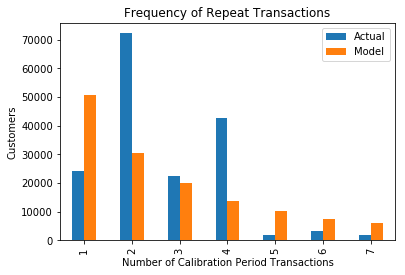

In [23]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

Based on customer history, we can predict what an individuals future purchases might look like:

In [24]:
t = 10 #predict purchases in 10 periods
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, rfmTable['F'], rfmTable['R'], rfmTable['T']).head()

document_number
000005678     8.583218e-05
00000S942     1.005127e-02
00002BO36     3.466812e-01
00003BJ30    2.067995e-149
00003BO60     4.261204e-05
dtype: float64

In [25]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

## Estimating Customers' Lifetime Value

Until now we haven't taken into account the economic value of each transaction and we focused mainly on transactions' occurrences. 

To estimate the economic value of each transaction we can use the Gamma-Gamma submodel. 

In [26]:
#First we need to create summary data from transactional data also containing economic values for each transaction.
summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

print(returning_customers_summary.head())

             frequency  recency      T  monetary_value
customer_id                                           
1                    2    30.43  38.86           22.35
2                    1     1.71  38.86           11.77
6                    7    29.43  38.86           73.74
7                    1     5.00  38.86           11.77
9                    2    35.71  38.86           25.55


The Gamma-Gamma submodel assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [27]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.113884
frequency,0.113884,1.000000


We can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [28]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>


We can now estimate the average transaction value:

In [30]:
print(ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']).head(10))

customer_id
1     24.658622
2     18.911496
3     35.170995
4     35.170995
5     35.170995
6     71.462842
7     18.911496
8     35.170995
9     27.282412
10    35.170995
dtype: float64


In [31]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()))

Expected conditional average profit: 35.2529536057, Average profit: 35.078551797
